In [11]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 1. Load dataset
df = pd.read_csv('cleaned_car_data.csv')
df = df[df['price'] < 250000]  # Remove outliers

# 2. Convert 'clean_title' to binary
df['clean_title'] = df['clean_title'].map({'Yes': 1, 'No': 0}).astype(int)

# 3. Target encode high-cardinality features
df['brand_encoded'] = df.groupby('brand')['price'].transform('mean')
df['model_encoded'] = df.groupby('model')['price'].transform('mean')
df['engine_encoded'] = df.groupby('engine')['price'].transform('mean')
df['transmission_encoded'] = df.groupby('transmission')['price'].transform('mean')

# 4. Extract HP
def extract_hp(engine_str):
    match = re.search(r'(\d+(?:\.\d+)?)\s*hp', str(engine_str).lower())
    return float(match.group(1)) if match else np.nan

df['HP'] = df['engine'].apply(extract_hp)
df['HP'].fillna(df['HP'].median(), inplace=True)

# 5. Bin mileage
df['mileage_binned'] = pd.qcut(df['mileage'], q=10, labels=False)

# 6. Define features
numerical_features = ['model_year', 'mileage_binned', 'HP']
binary_features = ['clean_title']
target_encoded_features = ['brand_encoded']  # Removed other encoded features
categorical_features = ['fuel_type', 'ext_col', 'int_col', 'accident']

# 7. One-hot encode low-cardinality features
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True)

# 8. Combine features
X = pd.concat([df[numerical_features + binary_features + target_encoded_features], df_encoded], axis=1)
y = np.log1p(df['price'])  # Log-transform target

# 9. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 10. Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 11. Train Linear Regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 12. Predict and inverse-transform
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

# 13. Clean bad values before evaluation
bad_mask = ~np.isfinite(y_pred) | ~np.isfinite(y_test_actual)
if bad_mask.any():
    print(f"⚠️ Removing {bad_mask.sum()} rows with NaN/Inf values before scoring.")
    y_pred = y_pred[~bad_mask]
    y_test_actual = y_test_actual[~bad_mask]

# 14. Evaluation
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"Root Mean Squared Error: {np.sqrt(mse):,.2f}")
print(f"Mean Absolute Error: {mae:,.2f}")
print(f"R^2 Score: {r2:.4f}")

# 15. Save predictions
X_test_copy = pd.DataFrame(X_test, columns=X.columns)
X_test_copy = X_test_copy[~bad_mask].copy()
X_test_copy['predicted_price'] = y_pred
X_test_copy['actual_price'] = y_test_actual.values
X_test_copy['pct_error'] = ((X_test_copy['predicted_price'] - X_test_copy['actual_price']) / X_test_copy['actual_price']) * 100
X_test_copy['abs_pct_error'] = X_test_copy['pct_error'].abs()
X_test_copy.to_csv('test_predictions_with_errors.csv', index=False)


/var/folders/43/m0vmnltx4jq7xszgbwt_cnzc0000gn/T/ipykernel_86572/2186867861.py:60: RuntimeWarning: overflow encountered in expm1
  y_pred = np.expm1(y_pred_log)


ValueError: Input contains infinity or a value too large for dtype('float64').

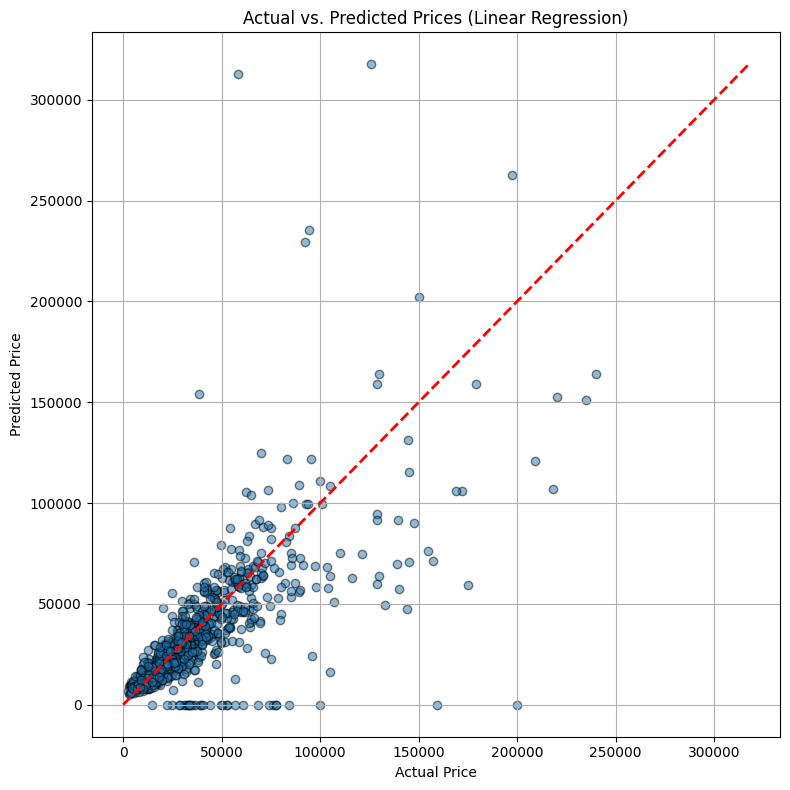

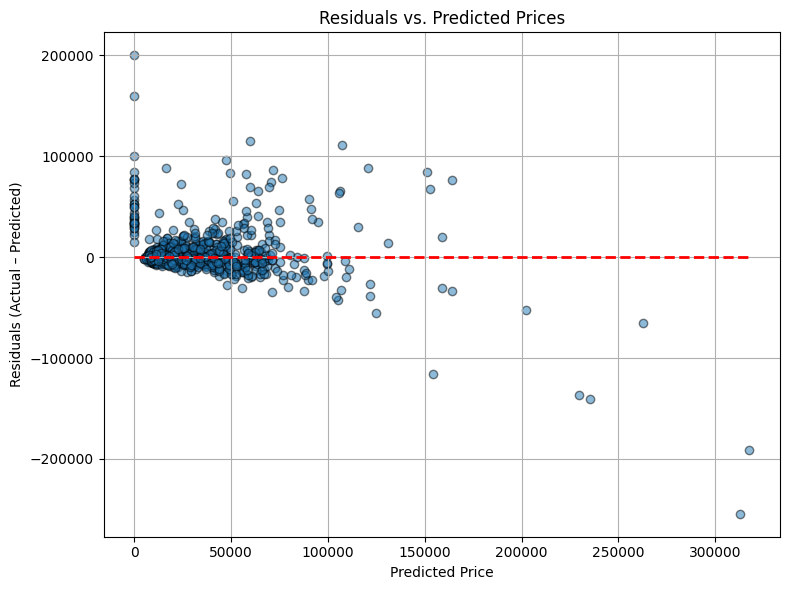

In [ ]:
import matplotlib.pyplot as plt

# 1. Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test_actual, y_pred, alpha=0.5, edgecolor='k')
max_val = max(y_test_actual.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices (Linear Regression)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residuals plot: Predicted vs Residuals
residuals = y_test_actual - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
plt.hlines(0, y_pred.min(), y_pred.max(), colors='r', linestyles='--', linewidth=2)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals (Actual – Predicted)')
plt.title('Residuals vs. Predicted Prices')
plt.grid(True)
plt.tight_layout()
plt.show()


KNN - Root Mean Squared Error: 23,623.58
KNN - Mean Absolute Error: 13,569.55
KNN - R^2 Score: 0.5445


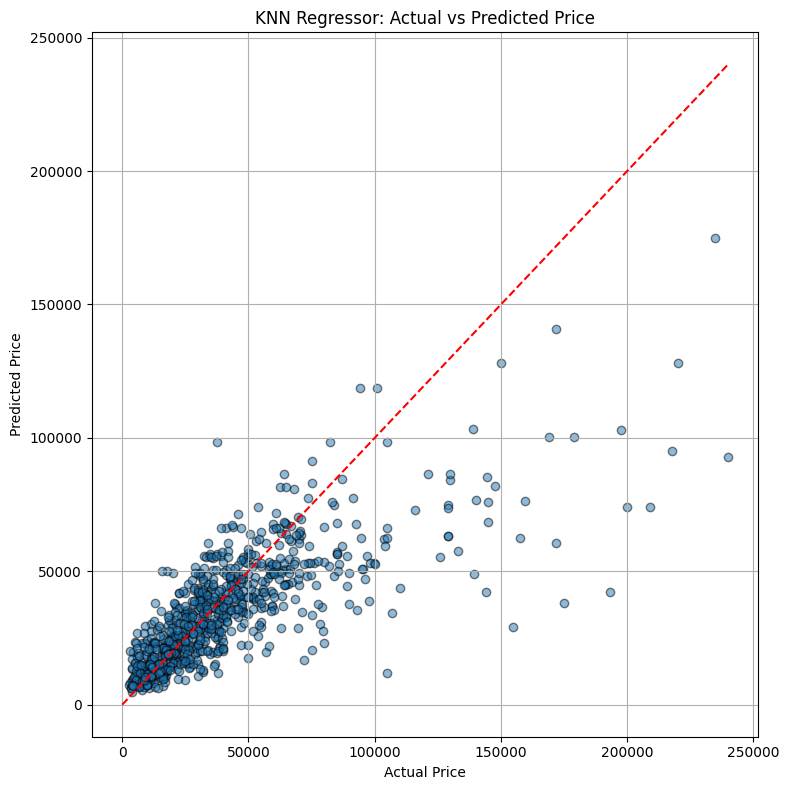

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_csv('cleaned_car_data.csv')
df = df[df['price'] < 250000]  # Remove outliers

# 2. Convert 'clean_title' to binary
df['clean_title'] = df['clean_title'].map({'Yes': 1, 'No': 0}).astype(int)

# 3. Target encode high-cardinality features
df['brand_encoded'] = df.groupby('brand')['price'].transform('mean')
df['model_encoded'] = df.groupby('model')['price'].transform('mean')
df['engine_encoded'] = df.groupby('engine')['price'].transform('mean')
df['transmission_encoded'] = df.groupby('transmission')['price'].transform('mean')

# 4. Extract HP
def extract_hp(engine_str):
    match = re.search(r'(\d+(?:\.\d+)?)\s*hp', str(engine_str).lower())
    return float(match.group(1)) if match else np.nan

df['HP'] = df['engine'].apply(extract_hp)
df['HP'].fillna(df['HP'].median(), inplace=True)

# 5. Bin mileage
df['mileage_binned'] = pd.qcut(df['mileage'], q=10, labels=False)

# 6. Define features
numerical_features = ['model_year', 'mileage_binned', 'HP']
binary_features = ['clean_title']
target_encoded_features = ['brand_encoded']  # Removed others
categorical_features = ['fuel_type', 'ext_col', 'int_col', 'accident']

# 7. One-hot encode categorical features
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True)

# 8. Combine features
X = pd.concat([df[numerical_features + binary_features + target_encoded_features], df_encoded], axis=1)
y = np.log1p(df['price'])  # Log-transform target

# 9. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 10. Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 11. Train KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# 12. Predict and inverse log transform
y_pred_log = knn.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

# 13. Clean bad values
bad_mask = ~np.isfinite(y_pred) | ~np.isfinite(y_test_actual)
if bad_mask.any():
    print(f"⚠️ Removing {bad_mask.sum()} rows with NaN/Inf values.")
    y_pred = y_pred[~bad_mask]
    y_test_actual = y_test_actual[~bad_mask]

# 14. Evaluation
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"KNN - Root Mean Squared Error: {np.sqrt(mse):,.2f}")
print(f"KNN - Mean Absolute Error: {mae:,.2f}")
print(f"KNN - R^2 Score: {r2:.4f}")

# 15. Plot Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test_actual, y_pred, alpha=0.5, edgecolor='k')
max_val = max(y_test_actual.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("KNN Regressor: Actual vs Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()
